In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
### initial conditions
temp_init, p_init   = 273.15, 100000                   # initial temp & pressure
relh_init           = 60                               # initial relative humidity (%)
qc_init             = 0                                # initial liquid water content

### integration params
tspan          = [0, 1200]                       # time span of integration [s]
ntout          = 1000                            # no time points to evaluate (save data at)
method         = 'LSODA'
maxtstep       = 0.1                             # [s]
rtol           = 1e-8                            # relative tolerance (tol) for integration
atols          = 1e-6                            # absolute tolerance
  
### superdroplet parameters
rspan            = [1e-8, 1e-5]                      # initial range of droplet radii [m]
nsupers          = 20                                # no. of distinct superdrops (different initial radii (evenly spaced between ln(rspan))
r_init = np.logspace(np.log10(rspan[0]), np.log10(rspan[1]), nsupers)

ionic = 2
mr_sol = 0.058443
rho_sol = 2200
m_sol = rho_sol*4/3*np.pi*r_init**3             # assuming initially dry areosol droplets (dimless mass_solute)

### some constants
rho_l = 1000
R            = 8.314462618       # Universal Molar Gas Constant [J/mol/K]
Mr_water     = 0.01801528        # molecular mass of water
Mr_dry       = 0.0289647         # molecular mass (per 1 mole) of dry air (M_r)       
mr_ratio     = Mr_water/Mr_dry
Rgas_dry     = R/Mr_dry          # specific gas constant for dry air [J/Kg/K]      <-- used in ideal gas equation for hydrostsic rather than moist??
Rgas_v       = R/Mr_water        # specific gas constant for water
Latent_v     = 2437300       
mr_ratio     = Mr_water/Mr_dry

# cp_dry       = 1004.9            # specific heat capacity (dry) air at const. pressure [J/Kg/K] (taken at 300K)   = 1.400*cv_dry 
# cp_v         = 1864              # specific heat capacity of water vapour [J/Kg/K] (at 300K)
# c_l          = 4180              # specific heat capacity of liquid water[J/Kg/K] (at 300K)

In [3]:
def pv2qv(pv, p):
    ''' calculate mass mixing ratio
    qv = m_v/m_dry = rho_v/rho_dry
    given vapour pressure pv = p_v/p_tot.'''
    
    qv = mr_ratio * pv/(p-pv)
    
    return qv


def qv2pv(qv, p):
    ''' calculate vapour pressure
    pv = p_v/p_tot
    given mass mixing ratio 
    qv = m_v/m_dry = rho_v/rho_dry.
    True pv = pv * P0'''
    
    pv = p*qv/(mr_ratio+qv)
    
    return pv


# def cp_moist(qv, qc):
#     ''' calculate effecitve specific heat 
#     capacity of parcel with water vapour 
#     qv=m_v/m_dry and liquid water qc= m_l/m_dry
#     (notice m_dry not m_tot). Enthalpy change of
#     parcel per unit (total) mass = dh. 
#     (1+qv+qc)dh = cp_eff*dtemp + latent_v*dqv.
#     true cp_moist = Cp0 * cp_moist.'''

#     cp_moist = cp_dry + cp_v*qv + c_l*qc 
    
#     #cp = cp_dry * (1+qv*cp_v/cp_dry)/(1+qv)
    
#     return cp_moist

In [4]:
def saturation_pressure(T, Temp0=1, P0=1):
    ''' Calculate the equilibrium vapor pressure 
    of water over liquid water ie. the
    saturation pressure (psat). Equation taken from
    typhon.physics.thermodynamics.e_eq_water_mk.
    Real temp = T*Temp0, dimensionless psat = psat/P0'''

    T = T*Temp0                               # real T [K]
    
    if np.any(T <= 0):
        err = 'T must be larger than 0K.'
        raise ValueError(err)

    lnpsat = (54.842763                    # ln(psat) [Pa]
         - 6763.22 / T
         - 4.21 * np.log(T)
         + 0.000367 * T
         + np.tanh(0.0415 * (T - 218.8))
         * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T))

    return np.exp(lnpsat)/P0               # dimensionless psat


def diffusion_factors(temp, p, psat, Temp0=1, P0=1, R0=1, Rho0=1, T0=1):
    ''' calculate Fkl and Fdl heat and vapour
    diffusion factors in equation for 
    radial growth of droplets according to
    eq.7.27 lohmann, luond and mahrt intro 2 
    clouds textbook '''

    Thermk273 = 0.023822892 - 7.11756e-5*273.15              #[eq.7.24 lohmann intro 2 clouds] [J/s/m/K]
    Diffuse_v273 = 2.11e-5 * 101325 / (273.15**1.94)         #[eq.7.26 lohmann intro 2 clouds] [m^2/s]

    temp, p, psat = temp*Temp0, p*P0, psat*P0

    # diffusional growth equation factors
    Rhermk = 7.11756e-5*temp + Thermk273                     #[eq.7.24 lohmann intro 2 clouds]
    Diffuse_v = Diffuse_v273 / p * temp**1.94
    
    Fkl = (Latent_v/(Rgas_v*temp) -1)*Latent_v/(Rhermk*temp) 
    Fdl = Rgas_v*temp/(Diffuse_v*psat)
    
    F0 = T0/(Rho0*R0**2)
    fkl = Fkl/F0                                          # dimless diffusion factors
    fdl = Fdl/F0 

    
    return fkl, fdl


In [5]:
def condensation_ode(t, r, temp, p, qv, qc, 
        ionic, m_sol, mr_sol, rho_l, rho_sol):
    ''' diffusion growth of droplets by condensation
    given temperature, pressure and qv.
    NOTE! shrinking by evaporation not includeded, nor
    are ventillation effects fv(r) (see Seifert & stevens 2010)'''
        
    # supersaturation of parcel
    psat = saturation_pressure(temp)
    s_ratio = qv2pv(qv, p)/psat                                      # ambient supersaturation ratio 
    a = 3.3e-7/temp
    b = 43e-6*ionic*m_sol/mr_sol
    
    # radial growth/shrink of droplets
    fkl, fdl = diffusion_factors(temp, p, psat)                             
    dr = (s_ratio-1 -a/r +b/r**3) / (rho_l * (fkl+fdl) * r)           # [eq.7.27 lohmann intro 2 clouds]
    #dr = (s_ratio-1) / (rho_l * (fkl+fdl) * r)           # [eq.7.27 lohmann intro 2 clouds]

    # dry_r = (3*m_sol/(4*np.pi*rho_sol))**(1/3) 
    # if (r <= dry_r).any():                                       # if droplets are dry, do not shrink further
    #     dry_drs = np.where(r<=dry_r, dr, 0.0)
    #     dr = np.where(dry_drs<0.0, 0.0, dr)
    #     r = np.where(r <= dry_r, dry_r, r)
    
    return dr


In [6]:
pv_init = relh_init/100 * saturation_pressure(temp_init)     # initial water vapour pressure
qv_init = pv2qv(pv_init, p_init)                             # initial water mass mixing ratio (mass water/mass dry air)

args = [temp_init, p_init, qv_init, qc_init,
         ionic, m_sol, mr_sol, rho_l, rho_sol]
t_eval = np.linspace(tspan[0], tspan[1], ntout)
sol = solve_ivp(condensation_ode, tspan, 
                r_init, method=method, t_eval=t_eval, args=args,
                   max_step=maxtstep, rtol=rtol, atol=atols) 


In [7]:

t = sol.t
r = sol.y
print(t.shape, r.shape)

(1000,) (20, 1000)


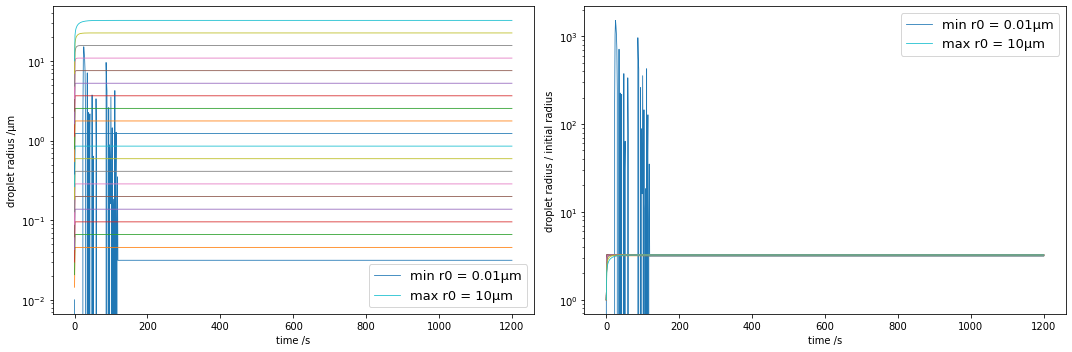

In [8]:
### plots of droplet radii growth
a=1
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r[:,0]]
for i in range(nsupers)[::a]:
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax1.plot(t, r[i]*1e6, linewidth=0.8, label=label)
  
ax1.set_xlabel('time /s')
ax1.set_ylabel('droplet radius /\u03BCm')
ax1.set_yscale('log')
ax1.legend(fontsize=13)

for i in range(nsupers)[::a]:    
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax2.plot(t, r[i]/r[i,0], linewidth=0.8, label=label) #,color=cols[i])
ax2.set_xlabel('time /s')
ax2.set_ylabel('droplet radius / initial radius')
ax2.set_yscale('log')
ax2.legend(fontsize=13)

plt.tight_layout()
# plt.savefig(savedir+"SDsolution.png", dpi=400, bbox_inches="tight", facecolor='w')
plt.show()